In [1]:
# Import tools we'll use
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 1 - Analysis

##### First, let's read in the data.

In [2]:
# Read in the data as a pandas dataframe (df)
food_app_df = pd.read_csv('./data/food_app.csv')
food_app_df.head()

,Year,Major,University,Time,Order
0,Year 2,Physics,Indiana State University,12,Fried Catfish Basket
1,Year 3,Chemistry,Ball State University,14,Sugar Cream Pie
2,Year 3,Chemistry,Butler University,12,Indiana Pork Chili
3,Year 2,Biology,Indiana State University,11,Fried Catfish Basket
4,Year 3,Business Administration,Butler University,12,Indiana Corn on the Cob (brushed with garlic b...


##### Let's check some high-level information about the data.

In [3]:
# Check high-level information about the data
food_app_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Year        5000 non-null   object
 1   Major       5000 non-null   object
 2   University  5000 non-null   object
 3   Time        5000 non-null   int64 
 4   Order       5000 non-null   object
dtypes: int64(1), object(4)
memory usage: 195.4+ KB


##### Four of the five columns are categorical, so we'll either need to convert those into a machine-readable format or use an algorithm that can work with categorical data (more on this later).  It also looks like there are no null values, but let's double check to be safe.

In [4]:
# Double check that there are no null values in any of the columns
food_app_df.isnull().sum()

Year          0
Major         0
University    0
Time          0
Order         0
dtype: int64

##### Indeed, there are no null values, so we don't need to worry about removing data points or filling in null values.  Since most of our features are categorical (including the target), let's see how many unique values each feature has.

In [5]:
# Prints out the number of unique values in each column
food_app_df.nunique()

Year           4
Major         20
University    10
Time          10
Order         10
dtype: int64

##### Let's now take a look at the distribution of each feature.

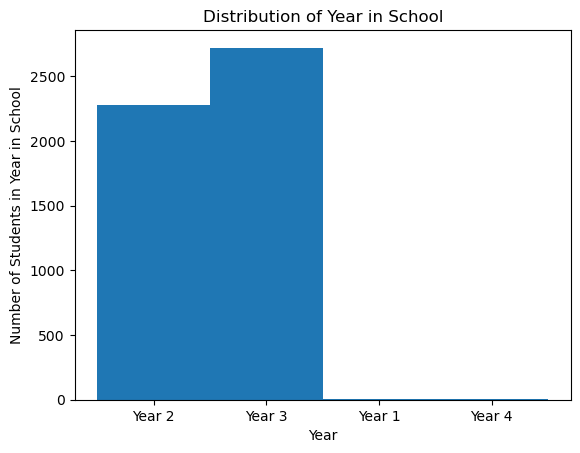

In [6]:
# Year
bins = np.arange(food_app_df['Year'].nunique() + 1) - 0.5
plt.hist(food_app_df['Year'], bins)
plt.title('Distribution of Year in School')
plt.xlabel('Year')
plt.ylabel('Number of Students in Year in School')
plt.show()

In [7]:
# Numeric version of the plot from above
food_app_df['Year'].value_counts()

Year 3    2719
Year 2    2273
Year 1       5
Year 4       3
Name: Year, dtype: int64

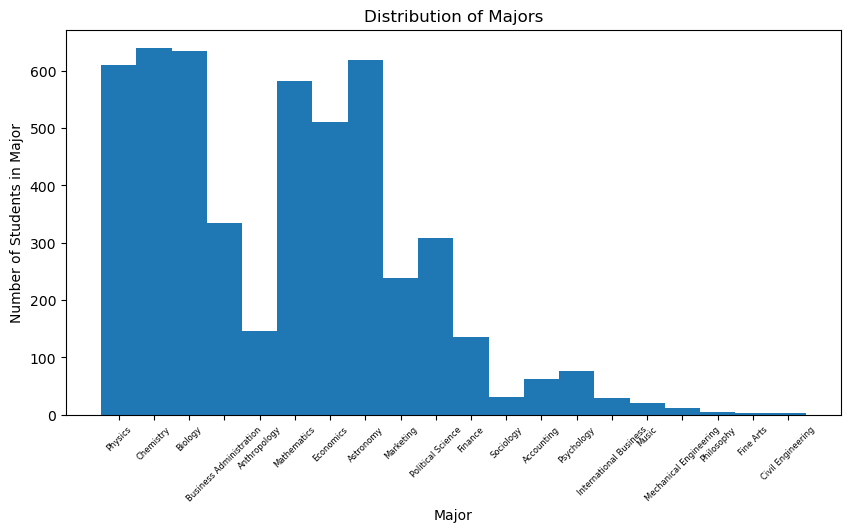

In [8]:
# Major
plt.figure(figsize=(10, 5))
bins = np.arange(food_app_df['Major'].nunique() + 1) - 0.5
plt.hist(food_app_df['Major'], bins)
plt.title('Distribution of Majors')
plt.xlabel('Major')
plt.ylabel('Number of Students in Major')
plt.xticks(rotation=45)
plt.xticks(fontsize=6)
plt.xticks(np.arange(0, 20))
plt.show()

In [9]:
# Numeric version of the plot from above
food_app_df['Major'].value_counts()

Chemistry                  640
Biology                    635
Astronomy                  619
Physics                    610
Mathematics                582
Economics                  511
Business Administration    334
Political Science          309
Marketing                  239
Anthropology               146
Finance                    135
Psychology                  76
Accounting                  62
Sociology                   31
International Business      29
Music                       21
Mechanical Engineering      11
Philosophy                   4
Fine Arts                    3
Civil Engineering            3
Name: Major, dtype: int64

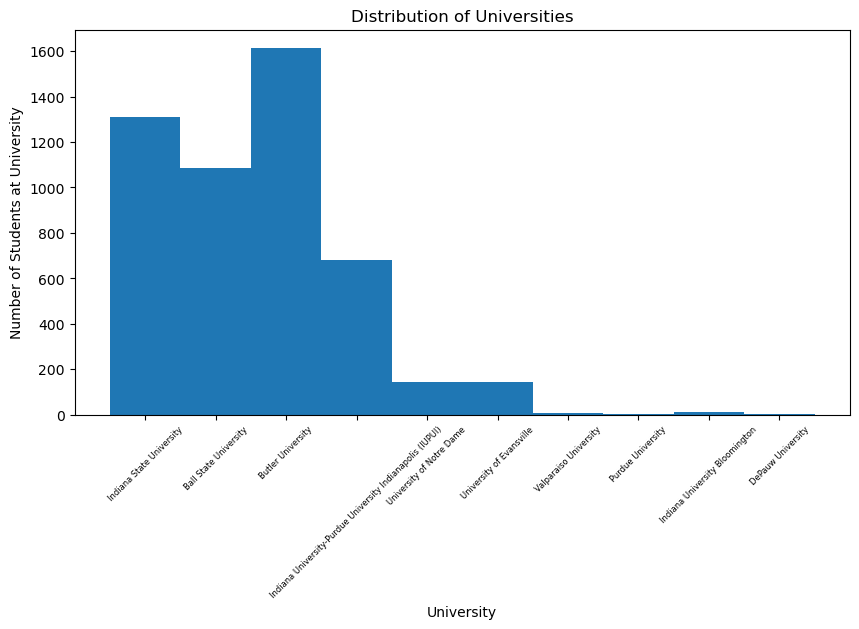

In [10]:
# University
plt.figure(figsize=(10, 5))
bins = np.arange(food_app_df['University'].nunique() + 1) - 0.5
plt.hist(food_app_df['University'], bins)
plt.title('Distribution of Universities')
plt.xlabel('University')
plt.ylabel('Number of Students at University')
plt.xticks(rotation=45)
plt.xticks(fontsize=6)
plt.show()

In [11]:
# Numeric version of the plot from above
food_app_df['University'].value_counts()

Butler University                                            1614
Indiana State University                                     1309
Ball State University                                        1085
Indiana University-Purdue University Indianapolis (IUPUI)     682
University of Notre Dame                                      144
University of Evansville                                      143
Indiana University Bloomington                                 12
Valparaiso University                                           9
Purdue University                                               1
DePauw University                                               1
Name: University, dtype: int64

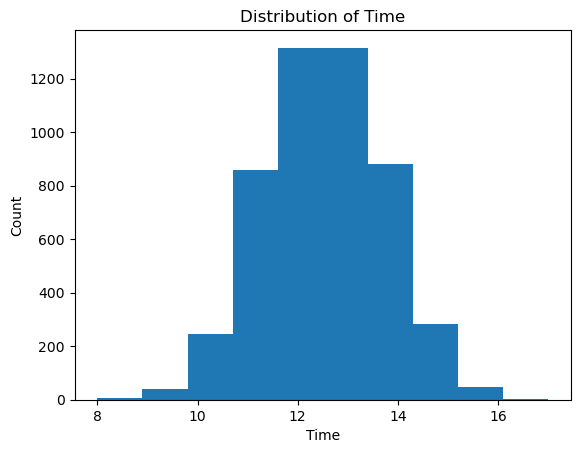

In [12]:
# Time
plt.hist(food_app_df['Time'])
plt.title('Distribution of Time')
plt.xlabel('Time')
plt.ylabel('Count')
plt.show()

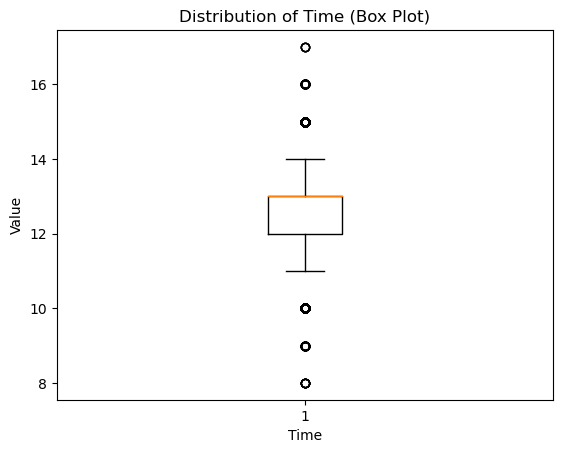

In [13]:
# Time (but with a boxplot)
plt.boxplot(food_app_df['Time'])
plt.title('Distribution of Time (Box Plot)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

##### Similar to the input features, let's look at the distribution of the target variable (order).

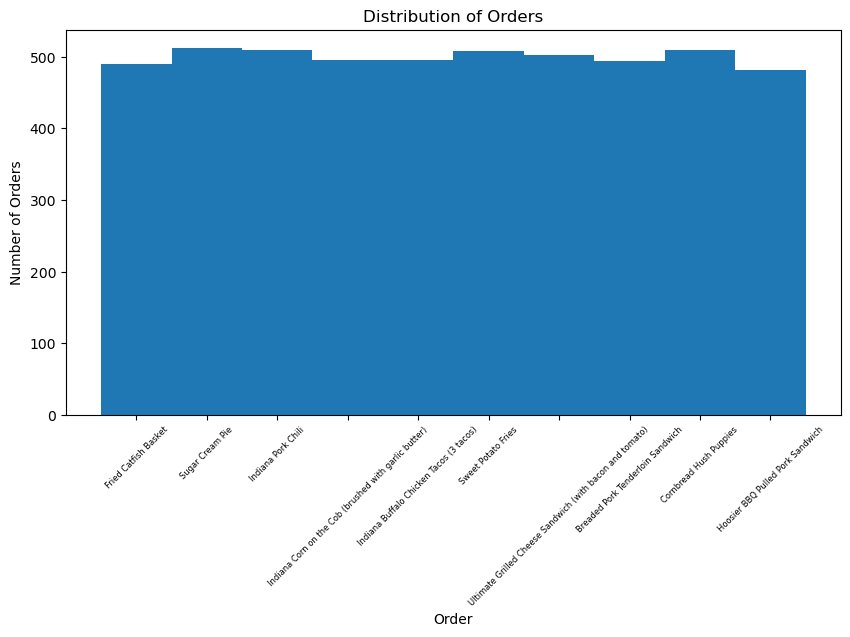

In [14]:
# Order
plt.figure(figsize=(10, 5))
bins = np.arange(food_app_df['Order'].nunique() + 1) - 0.5
plt.hist(food_app_df['Order'], bins)
plt.title('Distribution of Orders')
plt.xlabel('Order')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.xticks(fontsize=6)
plt.show()

In [15]:
# Numeric version of the plot from above
food_app_df['Order'].value_counts()

Sugar Cream Pie                                             512
Indiana Pork Chili                                          510
Cornbread Hush Puppies                                      510
Sweet Potato Fries                                          508
Ultimate Grilled Cheese Sandwich (with bacon and tomato)    503
Indiana Buffalo Chicken Tacos (3 tacos)                     496
Indiana Corn on the Cob (brushed with garlic butter)        495
Breaded Pork Tenderloin Sandwich                            494
Fried Catfish Basket                                        490
Hoosier BBQ Pulled Pork Sandwich                            482
Name: Order, dtype: int64

##### Let's discuss/summarize our findings.  We have four feature variables we can use to try to predict our target variable (order).  Three of those four features are categorical, though even the numeric "time" variable could be viewed as an ordinal categorical variable.  Our target variable appears to follow a uniform distribution, which means each class in the target is represented equally (which is good because we won't need to worry about balancing class labels).  As was mentioned earlier, we don't have any null values, which is also good because we won't need to worry about removing values or filling values in.  The "time" feature appears to roughly follow a normal distribution, though the box plot shows that there might be a handful of outliers.  The "year", "major" and "university" features also appear to contain outliers, where certain years, majors, and univeristies are much more represented than others (for example, year 2 vs. year 1, Chemistry vs. Fine Arts, Butler University vs. Purdue University, etc.).

# 2 - Implications

##### As requested, we will now discuss ethical, business outcome, and technical implications.

### 2.1 - Ethical Implications

##### Thankfully, there are no features containing personal identification information (i.e. name, birth date, email, phone number, social security number, etc.).  Additionally, the "time" feature that we are collecting is simply a date feature, so there probably are no ethical concerns with this variable.  However, we are collecting information about year in school, major, and unversity.  It is possible that the model we use to predict orders might develop undesirable biases against a particular school, major, and/or student class level (year in school).  Depending on if/how we use the model in production, these are biases that we might want to check for to be sure our model is as fair as possible.

### 2.2 - Business Outcome Implications

##### For one, there are multiple year groups, majors, and universities that are underrepresented in the data.  If we want our model to make accurate predictions for students in these groups, as a business we should try to collect more data, or perhaps bin the underrepresented groups into some form of "other" group.  Additionally, we should be aware that our model will only be able to make predictions for the groups that are represented in the data.  If a new group is introduced, the model will not be able to make a prediction for said group (unless we use an "other" group).  For example, if we would like to predict orders for students from a newly-institutionalized university, we would probably need to collect new data for students from that university and retrain our model.  Similarly, if we decide to add new items to the menu, the model will not be able to make predictions for those items until additional data has been collected and the model has been retrained.  We should also consider factors around data storage.  Student preferences might change over time, so as a business we should consider how long to store this data and our trained model before making updates.

### 2.3 - Technical Implications

##### The "year" feature is an ordinal categorical variable, so we could convert this to an ordinal numeric value (i.e. year 1 becomes 1, year 2 becomes 2, etc.).  However, we could also just use an algorithm that is able to work with categorical data (more on this in the next section).  The "time" feature is already a numerical variable (though, again, could be viewed as an ordinal categorical variable), and the "major" and "university" features will either need to be one-hot encoded (they are categorical but not ordinal) or passed to an algorithm that can work with categorical data.  Note that, if we wanted to make a more complex model, we could use a deep neural network and create embedding layers for these two categorical variables, rather than use one-hot encoding.  However, we won't worry about this for our purposes (since we're just using sklearn).  As was mentioned previously, we do not need to worry about null values or balancing class labels.  From a data storage perspective, we would want to consider where to store the model if we were to use it in production.  We might have our own servers we could use to serve up the model, or we could use cloud computing in order to avoid the headaches of mainting reliable (and possibly distributed) servers.  We would also want to take into consideration the size of our model and how long predictions take (since we're using this in a mobile application setting, we want predictions to be fast).  If our model is too large or takes too long to make predictions, we should consider using a simpler model, improving the speed of our servers, and/or distilling our model weights into a smaller model (if we were using a neural network).

# 3 - Model

##### First, let's put the input features and the target into two different dataframes (x_df and y_df, respectively).

In [16]:
# Extract the input features and label
x_df, y_df = food_app_df[['Year', 'Major', 'University', 'Time']].copy(), food_app_df[['Order']].copy()
print(x_df.head())
print(y_df.head())

     Year                    Major                University  Time
0  Year 2                  Physics  Indiana State University    12
1  Year 3                Chemistry     Ball State University    14
2  Year 3                Chemistry         Butler University    12
3  Year 2                  Biology  Indiana State University    11
4  Year 3  Business Administration         Butler University    12
                                               Order
0                               Fried Catfish Basket
1                                    Sugar Cream Pie
2                                 Indiana Pork Chili
3                               Fried Catfish Basket
4  Indiana Corn on the Cob (brushed with garlic b...


##### Let's now consider what we should do for our categorical variables.  As was mentioned previously, we either need to convert them to a numeric representation or use a model that can work directly with categorical data (for example, a decision tree).  Since we have been encourage to use sklearn in the problem prompt, and the current implementations of sklearn models (as of October, 2023) do not allow for the direct use of categorical variables, we will convert them to numeric representations.  Within x_df, the "year" feature is ordinal, so we can use a simple index mapping for conversion (year 1 maps to 1, year 2 maps to 2, etc.).  For the other features, we can use one-hot encoding by using pandas's get_dummies method.

In [17]:
# The "year" feature is ordinal
year_mapping = {'Year 1': 1, 'Year 2': 2, 'Year 3': 3, 'Year 4': 4}
x_df['Year'] = x_df['Year'].map(year_mapping)
x_df['Year'].unique()

array([2, 3, 1, 4])

In [18]:
# One-hot encode the two other categorical features
x_df_encoded = pd.get_dummies(x_df, columns=['Major', 'University'])
x_df_encoded.head()

,Year,Time,Major_Accounting,Major_Anthropology,Major_Astronomy,Major_Biology,Major_Business Administration,Major_Chemistry,Major_Civil Engineering,Major_Economics,...,University_Ball State University,University_Butler University,University_DePauw University,University_Indiana State University,University_Indiana University Bloomington,University_Indiana University-Purdue University Indianapolis (IUPUI),University_Purdue University,University_University of Evansville,University_University of Notre Dame,University_Valparaiso University
0,2,12,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,3,14,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
2,3,12,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
3,2,11,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,3,12,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0


##### Similar to what we did for x_df, let's use sklearn's label encoder to convert y_df (the labels) to numeric data.

In [19]:
# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(np.array(y_df).reshape(-1,))

# Show the encodings and the clases
print(y_encoded)
print(list(label_encoder.classes_))

[2 7 6 ... 7 7 0]
['Breaded Pork Tenderloin Sandwich', 'Cornbread Hush Puppies', 'Fried Catfish Basket', 'Hoosier BBQ Pulled Pork Sandwich', 'Indiana Buffalo Chicken Tacos (3 tacos)', 'Indiana Corn on the Cob (brushed with garlic butter)', 'Indiana Pork Chili', 'Sugar Cream Pie', 'Sweet Potato Fries', 'Ultimate Grilled Cheese Sandwich (with bacon and tomato)']


##### Now that both the input data and the labels are numeric, we can start the model training and testing process.  First, let's create separate training and testing data sets.  We'll use a common train/test split proportion of 0.75 (75% of the data is used for training while the other 25% is used for testing).

In [20]:
# Our data is now in numeric form, so we can create train and test sets
x_train, x_test, y_train, y_test = train_test_split(np.array(x_df_encoded), y_encoded, train_size=0.75)

# Make sure the amount of data in each x, y pair is equal
assert len(x_train) == len(y_train) and len(x_test) == len(y_test)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(3750, 32) (1250, 32) (3750,) (1250,)


##### For the sake of simplicity, let's try two different sklearn models and see which one generalizes the best (which one performs the best on the test set).  We'll compare a random forest classifier to a gradient boosting classifier.  Both models work well with categorical data, which could be useful in our case (essentially all of the input features are categorical).  Additionally, both are ensemble methods that train multiple decision trees to make predictions.  However, random forest is typically viewed as being more robust and interpretable, while gradient boosting might offer superior predictive power if trained properly.

##### Two things to note before we being the training process: 
##### 1 - We will use accuracy as our performance metric.  Not all classification problems are best-served with accuracy, but, as we noted in the previous sections, the class labels are balanced, so we don't need to worry about our model learning to only predict the most common classes.  Additionally, we probably are not concerned with precision or recall (or F1 score) for this particular problem.
##### 2 - Notice that we did not scale the input data.  This is because all of our features are categorical (even the "time" feature can be viewed as an ordinal categorical variable).


##### Let's start with random forest, and let's try different hyperparameters to find the best combination.  Since there are numerous possible combinations, we will run a randomized search instead of a full grid search (i.e. we will use RandomizedSearchCV instead of GridSearchCV).

In [21]:
# Different random forest hyperparameter values to experiment with
rf_params = {'n_estimators': [5, 10, 15, 20, 25, 50, 100, 200, 300], 
             'min_samples_leaf': [5, 10, 15, 20, 25, 50], 
             'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 
             'min_samples_split': [2, 3, 4, 5, 10, 15],
             'criterion': ['gini', 'entropy', 'log_loss']}

# Try different combinations of the hyperparameter values to find the combination that performs the best
search = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=rf_params, cv=5, n_iter=50)
search.fit(x_train, y_train)

# Grab the best random forest model
random_forest = search.best_estimator_

# Print the training results
print(f'Random forest best parameters: {search.best_params_}')
print(f'Random forest training accuracy: {search.best_score_}')

Random forest best parameters: {'n_estimators': 200, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_depth': 10, 'criterion': 'log_loss'}
Random forest training accuracy: 0.6258666666666667


##### Now let's train the gradient boosting classifier (using a similar approach as to what we did with the random forest).

In [22]:
# Different gradient boosting hyperparameter values to experiment with
gradient_boosting_params = {'n_estimators': [5, 10, 15, 20, 25, 50, 100, 200, 300], 
                            'learning_rate': [0.01, 0.1, 0.2],
                            'min_samples_leaf': [5, 10, 15, 20, 25, 50], 
                            'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 
                            'min_samples_split': [2, 3, 4, 5, 10, 15]}

# Try different combinations of the hyperparameter values to find the combination that performs the best
search = RandomizedSearchCV(estimator=GradientBoostingClassifier(), param_distributions=gradient_boosting_params, cv=5, n_iter=50)
search.fit(x_train, y_train)

# Grab the best gradient boosting model
gradient_boosting = search.best_estimator_

# Print the training results
print(f'Gradient boost best parameters: {search.best_params_}')
print(f'Gradient boosting training accuracy: {search.best_score_}')

Gradient boost best parameters: {'n_estimators': 25, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_depth': 8, 'learning_rate': 0.2}
Gradient boosting training accuracy: 0.6629333333333333


##### Both models have been trained; let's see which one performs the best on the test set.

In [23]:
# Make test set predictions for each model
random_forest_test_pred = random_forest.predict(x_test)
gradient_boosting_test_pred = gradient_boosting.predict(x_test)

# Print the test set accuracy for each model
print(f'Random forest test accuracy: {accuracy_score(y_test, random_forest_test_pred)}')
print(f'Gradient boosting test accuracy: {accuracy_score(y_test, gradient_boosting_test_pred)}')

Random forest test accuracy: 0.5872
Gradient boosting test accuracy: 0.6376


##### We can see that the gradient boosting model seems to generalize better than the random forest model for this particular problem, so we will pickle it (and the label encoder) for future use.  Note however that, if we were very concerned about model interpretability, we might want to use the random forst model instead (but we'll assume that we are only concerned about performance).

In [24]:
# Pickle the gradient boosting model and the label encoder for future use (i.e. if we wanted to use this model in production)
model_path = './model/gradient_boosting'

with open(f'{model_path}_model.pickle', 'wb') as f:
    pickle.dump(gradient_boosting, f)

with open(f'{model_path}_label_encoder.pickle', 'wb') as f:
    pickle.dump(label_encoder, f)

##### Finally, as requested by the problem prompt, let's summarize the work we just did by creating two functions: one for converting our data into numeric data, and one for training our model

In [25]:
# Converts a data frame representing the input data (x) to a numpy array
def convert_input_data(input_data: pd.DataFrame) -> np.array:
    input_data_copy = input_data.copy()
    year_mapping = {'Year 1': 1, 'Year 2': 2, 'Year 3': 3, 'Year 4': 4}
    input_data_copy['Year'] = input_data_copy['Year'].map(year_mapping)
    input_data_copy = pd.get_dummies(input_data_copy, columns=['Major', 'University'])

    return np.array(input_data_copy)

# Trains and tests a gradient boosting model and pickles the final model
def train_and_test(data: pd.DataFrame) -> None:
    # Convert the data to numpy arrays
    x_df, y_df = data[['Year', 'Major', 'University', 'Time']].copy(), data[['Order']].copy()
    x = convert_input_data(x_df)
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(np.array(y_df).reshape(-1,))  

    # Create train and test sets
    x_train, x_test, y_train, y_test = train_test_split(np.array(x_df_encoded), y_encoded, train_size=0.75)

    assert len(x_train) == len(y_train) and len(x_test) == len(y_test)  

    print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

    # Train the gradient boosting model
    gradient_boosting_params = {'n_estimators': [5, 10, 15, 20, 25, 50, 100, 200, 300], 
                                'learning_rate': [0.01, 0.1, 0.2],
                                'min_samples_leaf': [5, 10, 15, 20, 25, 50], 
                                'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 
                                'min_samples_split': [2, 3, 4, 5, 10, 15]}

    grid_search = RandomizedSearchCV(estimator=GradientBoostingClassifier(), param_distributions=gradient_boosting_params, cv=5, n_iter=50)
    grid_search.fit(x_train, y_train)

    gradient_boosting = grid_search.best_estimator_

    print(f'Gradient boost best parameters: {grid_search.best_params_}')
    print(f'Gradient boosting training accuracy: {grid_search.best_score_}')

    # Run the trained model on the test set
    gradient_boosting_test_pred = gradient_boosting.predict(x_test)

    # Print the test set accuracy for each model
    print(f'Gradient boosting test accuracy: {accuracy_score(y_test, gradient_boosting_test_pred)}')

    # Save the model and the label encoder
    model_path = './model/gradient_boosting'

    with open(f'{model_path}_model.pickle', 'wb') as f:
        pickle.dump(gradient_boosting, f)

    with open(f'{model_path}_label_encoder.pickle', 'wb') as f:
        pickle.dump(label_encoder, f)

# 4 - Discussion

##### With the best model we explored, we were able to achieve roughly 64% accuracy on orders, which means that roughly one third of customers will receive a 10% discount on their order when the model incorrectly makes a prediction.  If, as a business, we feel that this is an acceptable threshold (for example, maybe this promotion encourages more students to order from our food truck, so taking a 10% hit on approximately one third of our orders might be worth it in order to bring in more customers), then we could leave this model as is.  However, considering how relatively little model exploration we ran (we only tried two different sklearn models), it would probably be worthwhile to spend at least a little more time on exploration in order to possibly find a superior model.  Additionally, as was mentioned earlier, it might be valuable to attempt to balance out some of the representation across schools, years, and majors in our data set (this might boost model performance), or combine/bin underrepresented groups into a group of their own (i.e. an "other" group).  Related to this, if we anticipate adding new items to the menu on a frequent basis, or serving students with years, majors, and/or universities that our model has never seen before, we would probably need to rethink how to process the data for our model.